<a href="https://colab.research.google.com/github/juanmadlg/K-armed-Bandit-Problem/blob/main/K_Armed_Testbed_with_Upper_Confidence_Bound_(UCB)_Action_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## k-armed Testbed with Upper-Confidence Bound (UCB) Action Selection

This is a new version of the K-Armed Testbed. These are the previous versions:
* [K-armed Testbed](https://gist.github.com/juanmadlg/bc25bc44af651d2dde48b708c2af87d9)
* [K-armed Testbed with Optimistic Initial Values](https://gist.github.com/juanmadlg/1aedc22ca5fead9deae902509fe417bd)

This is an update of the previous version that allows the evaluation of the Upper-Confidence Bound (UCB) Action Selection. 

UCB Action Selection is based on selecting the action based on the confidence that you have in the Q(a) value. This is based on the number of times that the action has been selected during the previous timesteps. More times selected, more confidence on Q(a) value.

This is the formula to select the action:

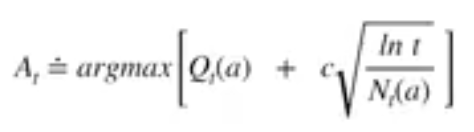


At = argmax[exploitation + exploration]

**Note:** This Notebook has been created in Google Colab.

## Packages

We will use the following packages:

- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [jdc](https://alexhagen.github.io/jdc/) : Jupyter magic that allows defining classes over multiple jupyter notebook cells.
- [tqdm](https://tqdm.github.io/) : A package to display progress bar when running experiments.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.

In [ ]:
!pip install jdc

In [ ]:
# Imports
import sys
from math import sqrt, log
import numpy as np
import jdc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## K-Arms Class

These are the elements included in the K-Arms Class
* **k**: The number of Arms
* **Q**: It stores the Function Values for each Arm. Vector of size (k, )
* **q_ini**: Initial value. Used for Optimistic inizialization. 0.0 in this experiment.
* **A**: It stores the number of 'executions' of the specific Arm. Vector of size (k, ). Initializated each time 'reset' is executed.
* **arms_mean**: Mean for the distribution of the Q* for each Arm
* **standard_deviation**: It is used in two cases: 
  * To generate the random distribution of the Q* for each Arm 
  * To generate the random value of an Arm when it is executed (using the on the Q* of the arm as a mean).
* **action_selection**: class that implements the action selection algorithmn

In [ ]:
class k_armed:
  def __init__(self, configuration, action_selection):
    '''
    Configuration is a dictionary that includes all diferente required settings
    '''
    self.Q = None
    self.N = None
    self.A = None
    self.k = configuration['k'] # Number of Arms
    self.q_ini = configuration['q_ini'] # Optimistic Inicial Value
    self.n_ini = configuration['n_ini'] 

    self.action_selection = action_selection;

    self.arms_mean = configuration['arms_mean']
    self.standard_deviation = configuration['std_dev'] # For Arms Distribution and Arms values

  def reset(self):
    '''
    Reset is executed at the begining of each episode. It sets to 0 Q and N
    and creates a new distribution of Q* for the k arms.
    '''
    self.Q = np.full((self.k, ), self.q_ini) # Initialize optimistic values
    self.N = np.full((self.k, ), self.n_ini)
    self.A = np.random.normal(loc=self.arms_mean, scale=self.standard_deviation, size=(self.k,))

### Action Selection Algorithm

I have updated the k_armed class to have a way set different get_action methods to compare the algorithms



In [ ]:
%%add_to k_armed

def get_action(self):
  '''
  Action selection: exploration vs. exploitation
  '''
  return self.action_selection.get_action(self.Q, self.N)

#### Epsilon-Greedy Action Selection

Lets keep epsilon-greedy to compare the different algorithms.

In [ ]:
class EpsiloGreedyActionSelection:

  def __init__(self, configuration):
     self.epsilon = configuration['epsilon']
     self.k = configuration['k'] 

  def get_action(self, Q, N):
    '''
    €-greedy action selection: exploration vs. exploitation
    '''
    if np.random.random_sample() <= self.epsilon:
      return np.random.randint(self.k) # Exploration

    return np.argmax(Q) # Exploitation

#### Upper-Confidence Bound (UCB) Action Selection


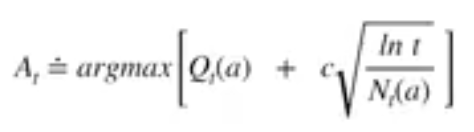

In [ ]:
class UCBActionSelection:
  def __init__(self, configuration):
    self.c = configuration['c']
    self.k = configuration['k']

  def get_action(self, Q, N):
    '''
    UCB Action Selection
    '''
    return np.argmax([Q[a] + self.c * sqrt(log(np.sum(N)) / N[a]) if N[a] else sys.float_info.max for a in range(self.k)])

### Bandit

Returns a random value in a normal distribution with Q*(arm) and the standard_deviation

In [ ]:
%%add_to k_armed

def bandit(self, a):
  '''
  Gets value of the selected arm based on a normal distribution with Q*(a) as the mean
  '''
  return np.random.normal(self.A[a], self.standard_deviation)

### k-armed Execution

For each step:
* Get the Action (Arm) (UCB or €-greedy action selection)
* Get the Value (Reward) for that Arm
* Increment the number of Steps
* Calculate the Value Function for the Arm: Qn+1 = Qn + (Rn - Qn) / n  

In [ ]:
%%add_to k_armed

def exec(self, steps):
  self.reset()

  rewards = []
  for i in range(steps):

    A = self.get_action()
    R = self.bandit(A)

    self.N[A] += 1
    self.Q[A] = self.Q[A] + (R - self.Q[A]) / self.N[A] # Update Value Function Q(a)

    rewards.append(R)

  return rewards

## Evaluate the Rewards

### Evaluate different c values in UCB version

We cannot evaluate the diference only with an execution for each c value. The curve is too noisy.

To evaluate the different values of c we are going to execute N different runs an calculate the average for each step.

In [ ]:
def evaluate(configuration, test_values, steps, runs):
  rewards = []

  # For these three c values
  for c in test_values:
    print(f'Execution {runs} runs with c={c}')
    action_selection = UCBActionSelection({'c': c, 'k': configuration['k']})

    e_k_armed = k_armed(configuration, action_selection)
    ucb_rewards = np.zeros((steps, ))

    # Lets execute son independent runs
    for _ in tqdm(range(runs)):
      ucb_rewards = np.add(ucb_rewards, e_k_armed.exec(steps))

    # Average for each step
    rewards.append(ucb_rewards / runs)

  return rewards

In [ ]:
configuration = {
    'k': 10,
    'c': None,
    'q_ini': 0.0, # Without optimal initialization values
    'n_ini': 0.0,
    'arms_mean': 1,
    'std_dev': 1
}

steps = 600
runs = 2000

rewards = evaluate(configuration, [1, 2, 5], steps, runs)

Execution 2000 runs with c=1




Execution 2000 runs with c=2



Execution 2000 runs with c=5


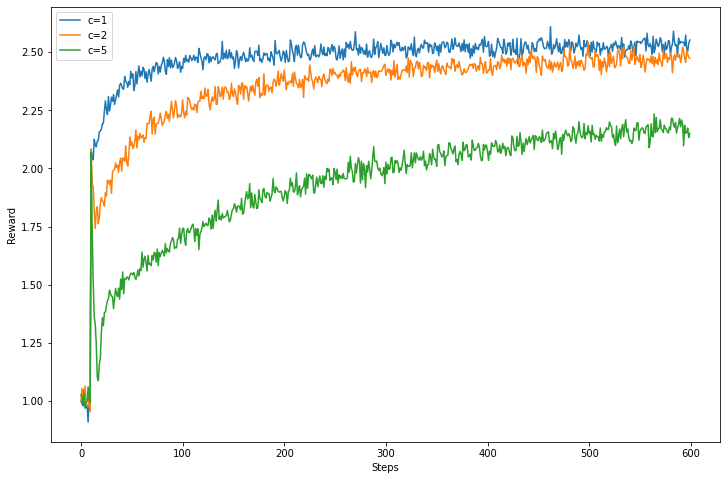

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(steps), rewards[0], label='c=1')
plt.plot(range(steps), rewards[1], label='c=2')
plt.plot(range(steps), rewards[2], label='c=5')
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.show()

**Conclusions**

We can see the different performances for the different values of c. For this specific scenario the best performance is provided with c = 1. Greater values of c does the algorithm to explore more or finally choose an action that is not so good.

### Execute epsilon-greeedy to compare

Let's execute the best version of the episilon-greed to compare it with UCB Action Selection

In [ ]:
def greedy_evaluate(configuration, epsilon, steps, runs):
  print(f'Execution {runs} runs with epsilon={epsilon}')
  action_selection = EpsiloGreedyActionSelection({'epsilon': epsilon, 'k': configuration['k']})

  e_k_armed = k_armed(configuration, action_selection)
  ucb_rewards = np.zeros((steps, ))

  # Lets execute son independent runs
  for _ in tqdm(range(runs)):
    ucb_rewards = np.add(ucb_rewards, e_k_armed.exec(steps))

  return ucb_rewards / runs

In [ ]:
configuration = {
    'k': 10,
    'e': None,
    'q_ini': 0.0, # Without optimal initialization values
    'n_ini': 0.0,
    'arms_mean': 1,
    'std_dev': 1
}

steps = 600
runs = 2000

e_rewards = greedy_evaluate(configuration, 0.1, steps, runs)

Execution 2000 runs with epsilon=0.1


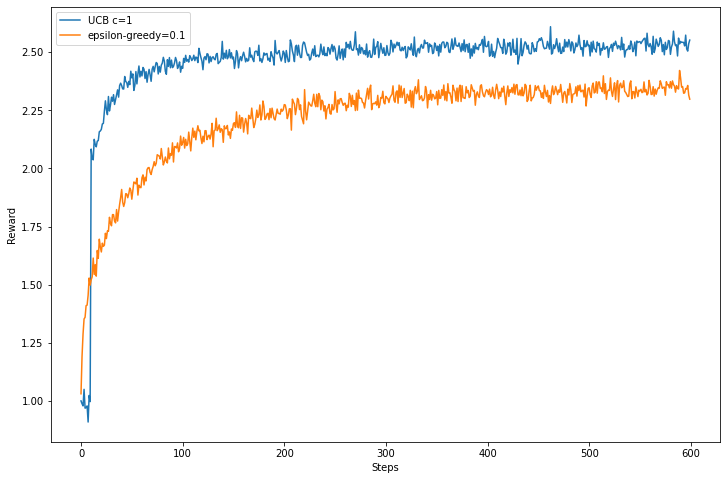

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(steps), rewards[0], label='UCB c=1')
plt.plot(range(steps), e_rewards, label='epsilon-greedy=0.1')
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.show()

**Conclusions**

We can see that UCB is better than the epsilon-greedy that provided the best performance in our previous tests (epsilon=0,1)

Why is it better?
The Epsilon-Greedy algorithm continues exploring during the full set of executions, but UCB Action Selection once discovers the best values quickly stops exploring to move to continuously exploit.